<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/Lab-Decision_Trees_and_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees and Random Forests

# Setup Jargon

## Libraries and Other Jargon
- Run the following cells to set up the notebook.
- When prompted for a selection, select the number that is associated with java 8 (this should be option 2)

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns; sns.set()

from struct import unpack
import json
from datetime import datetime
from collections import Counter
import glob
import re
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
!wget -nc https://storage.googleapis.com/penn-cis545/combined_anime.csv -O anime.csv

File ‘anime.csv’ already there; not retrieving.


## Dataset Cleaning and Preparation

This is **NOT** the focus of our recitation, so we've gone ahead and cleaned this data for you. Just run these cells for the purpose of our recitation.

If you want, feel free to come back here in your own time after the recitation to understand what cleaning tasks have been done. These may be quite similar to the EDA tasks you have to do in HW4!

In [ ]:
# Read original/raw data
anime_df = pd.read_csv('/content/anime.csv')

In [ ]:
# Dropping nulls and extra leftmost column
anime_df = anime_df.dropna(subset = {'anime_id', 'genre'})
anime_df = anime_df.drop(columns = ['Unnamed: 0'])

# Explode genre
anime_df['genre'] = anime_df['genre'].str.strip()
anime_df['genre'] = anime_df['genre'].str.split(',')
anime_df = anime_df.explode('genre')

# Take subset of anime_df as specified
desired_columns = ['anime_id', 'username', 'title', 'score',
                   'scored_by', 'rank', 'popularity', 'members',
                   'source', 'favorites', 'studio', 'genre']
new_anime_df = anime_df.loc[:, desired_columns]
new_anime_df = new_anime_df.dropna()
new_anime_df

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le_genre = LabelEncoder()
le_genre.fit(new_anime_df['genre'])
le_studio = LabelEncoder()
le_studio.fit(new_anime_df['studio'])
le_source = LabelEncoder()
le_source.fit(new_anime_df['source'])
le_title = LabelEncoder()
le_title.fit(new_anime_df['title'])

# Add as columns to new_anime_df
new_anime_df['genre_labels'] = le_genre.transform(new_anime_df['genre'])
new_anime_df['studio_labels'] = le_studio.transform(new_anime_df['studio'])
new_anime_df['source_labels'] = le_source.transform(new_anime_df['source'])
new_anime_df['title_labels'] = le_title.transform(new_anime_df['title'])

# Create classification target variable (whether score is > mean)
mean_score = anime_df['score'].mean()
new_anime_df['above_average'] = np.where(new_anime_df['score'] > mean_score, 1.0, 0.0)

# Export cleaned file to be used later in SparkML
new_anime_df.to_csv('/content/combined_anime.csv')

#### 💡 **Discussion Point** 💡
Let's take a look at our cleaned dataframe.
1. What kind of information does the `new_anime_df` dataset here contain?
2. Do you think it makes sense to _readily_ use all the columns of this dataframe as it is to build a classification model? What problems do you foresee?

In [ ]:
new_anime_df = pd.read_csv('/content/combined_anime.csv')

In [ ]:
# Peek
new_anime_df.head()

,Unnamed: 0,anime_id,username,title,score,scored_by,rank,popularity,members,source,favorites,studio,genre,genre_labels,studio_labels,source_labels,title_labels,above_average
0,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Slice of Life,69,14,5,3724,0.0
1,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Comedy,2,14,5,3724,0.0
2,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Music,57,480,10,2864,1.0
3,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,School,25,480,10,2864,1.0
4,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Slice of Life,32,480,10,2864,1.0


In [ ]:
cleaned_anime_df = new_anime_df.drop_duplicates(subset=['genre','studio','source','title','scored_by', 'popularity', 'favorites'])

In [ ]:
cleaned_anime_df.head(3)

,Unnamed: 0,anime_id,username,title,score,scored_by,rank,popularity,members,source,favorites,studio,genre,genre_labels,studio_labels,source_labels,title_labels,above_average
0,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Slice of Life,69,14,5,3724,0.0
1,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Comedy,2,14,5,3724,0.0
2,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Music,57,480,10,2864,1.0


In [ ]:
len(new_anime_df), len(new_anime_df\
                       .drop_duplicates(subset=['genre','studio','source','title',
                                                'scored_by', 'popularity', 'favorites']))

(1386393, 21460)

# Data Preprocessing: Clarifications about Standardization and Train-Test Splits

## 1. Constructing our feature dataframes ($\textbf{X}$) and label vector ($\vec{\textbf{y}}$)

In [ ]:
catgorical = ['genre', 'studio', 'source', 'title']
numerical = ['scored_by', 'popularity', 'favorites']

In [ ]:
# peek
for col in catgorical:
  print(col, Counter(cleaned_anime_df[col]).most_common()[:10])

genre [('Action', 1931), (' Comedy', 1439), ('Comedy', 1214), (' Fantasy', 1182), (' Shounen', 1114), (' Romance', 1059), (' Sci-Fi', 1024), (' Drama', 1004), (' School', 929), (' Supernatural', 801)]
studio [('Toei Animation', 1527), ('Sunrise', 1148), ('Madhouse', 997), ('J.C.Staff', 844), ('Studio Deen', 828), ('Studio Pierrot', 768), ('Production I.G', 625), ('TMS Entertainment', 574), ('A-1 Pictures', 553), ('OLM', 502)]
source [('Manga', 9396), ('Original', 5218), ('Light novel', 2059), ('Game', 1355), ('Visual novel', 992), ('Novel', 829), ('4-koma manga', 540), ('Other', 367), ('Web manga', 305), ('Card game', 131)]
title [('Ani*Kuri15', 13), ('Nihon Animator Mihonichi', 11), ('Asagiri no Miko', 11), ('Trinity Seven', 10), ('Kenpuu Denki Berserk', 10), ('InuYasha: Kanketsu-hen', 10), ('Berserk 2nd Season', 10), ('InuYasha', 10), ('Trinity Seven: Nanatsu no Taizai to Nana Madoushi', 10), ('Berserk', 10)]


In [ ]:
# consider the top 20 most popular values
for col in catgorical:
  keep_set = dict(Counter(cleaned_anime_df[col]).most_common()[:20]).keys()
  cleaned_anime_df[col] = cleaned_anime_df[col].apply(lambda x: x if x in keep_set else "Unknown")

In [ ]:
# create dummy varible for categorical columns
dummy_df = pd.get_dummies(cleaned_anime_df[catgorical])
dummy_df.shape

(21460, 78)

In [ ]:
dummy_df.head(2)

,genre_ Adventure,genre_ Comedy,genre_ Drama,genre_ Ecchi,genre_ Fantasy,genre_ Magic,genre_ Mecha,genre_ Romance,genre_ School,genre_ Sci-Fi,...,title_Kenpuu Denki Berserk,title_Macross 7,title_Mahou Sensei Negima!,title_Nihon Animator Mihonichi,title_Saber Marionette J,title_Trinity Seven,title_Trinity Seven: Nanatsu no Taizai to Nana Madoushi,title_Unknown,title_Zero no Tsukaima,title_Zero no Tsukaima: Princesses no Rondo
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
# features: feature dataframe, or "design matrix", or simply X
features = pd.concat([cleaned_anime_df[numerical], dummy_df], axis = 1)

# labels: our label vector, or target variable, or simply y
labels = cleaned_anime_df['above_average']

In [ ]:
# Implied columns that were dropped from the df to create the feature matrix
set(new_anime_df) - set(features)

{'Unnamed: 0',
 'above_average',
 'anime_id',
 'genre',
 'genre_labels',
 'members',
 'rank',
 'score',
 'source',
 'source_labels',
 'studio',
 'studio_labels',
 'title',
 'title_labels',
 'username'}

## 2. Split Data into Train and Test

**Rationale**
- _The Issue:_ data is scarce...yet we still need to build a model that generalizes well beyond our dataset. How then would we assess the generalizability of our model if we use the entire dataset to train it?
- _The Workaround:_ we want to **_train_** our model on a major portion of the data, but save a portion of the data so that it is "unseen" by our model so that we can **_test_** how well it does with unfamiliar data points.

**Quick Primer: Overfitting and Underfitting**
- By having training and testing sets, we can evaluate/score them independently then make a judgment about how good our model is.
  - _Underfit:_ model performs poorly on both familiar data (training) and unfamiliar/unseen data (testing)
  - _Overfit:_ model performs well on familiar data (training) but not as well on unfamiliar/unseen data (testing). This suggests that our model became too acclimated to what it was trained with and cannot generalize well.

**Implementation**

Use scikit-learn's `train_test_split` function and split data into train and test sets. We're choosing to do an 80/20 split, meaning 80% for training and the remaining 20% for testing.

To make results reproduceable, **set the random_state parameter = 42** and store the resulting splits as `x_train`, `x_test`, `y_train`, and `y_test`.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state = 42, test_size = 0.2)

In [ ]:
x_train.shape, x_test.shape

((17168, 81), (4292, 81))

# Decision Trees


## Intuition

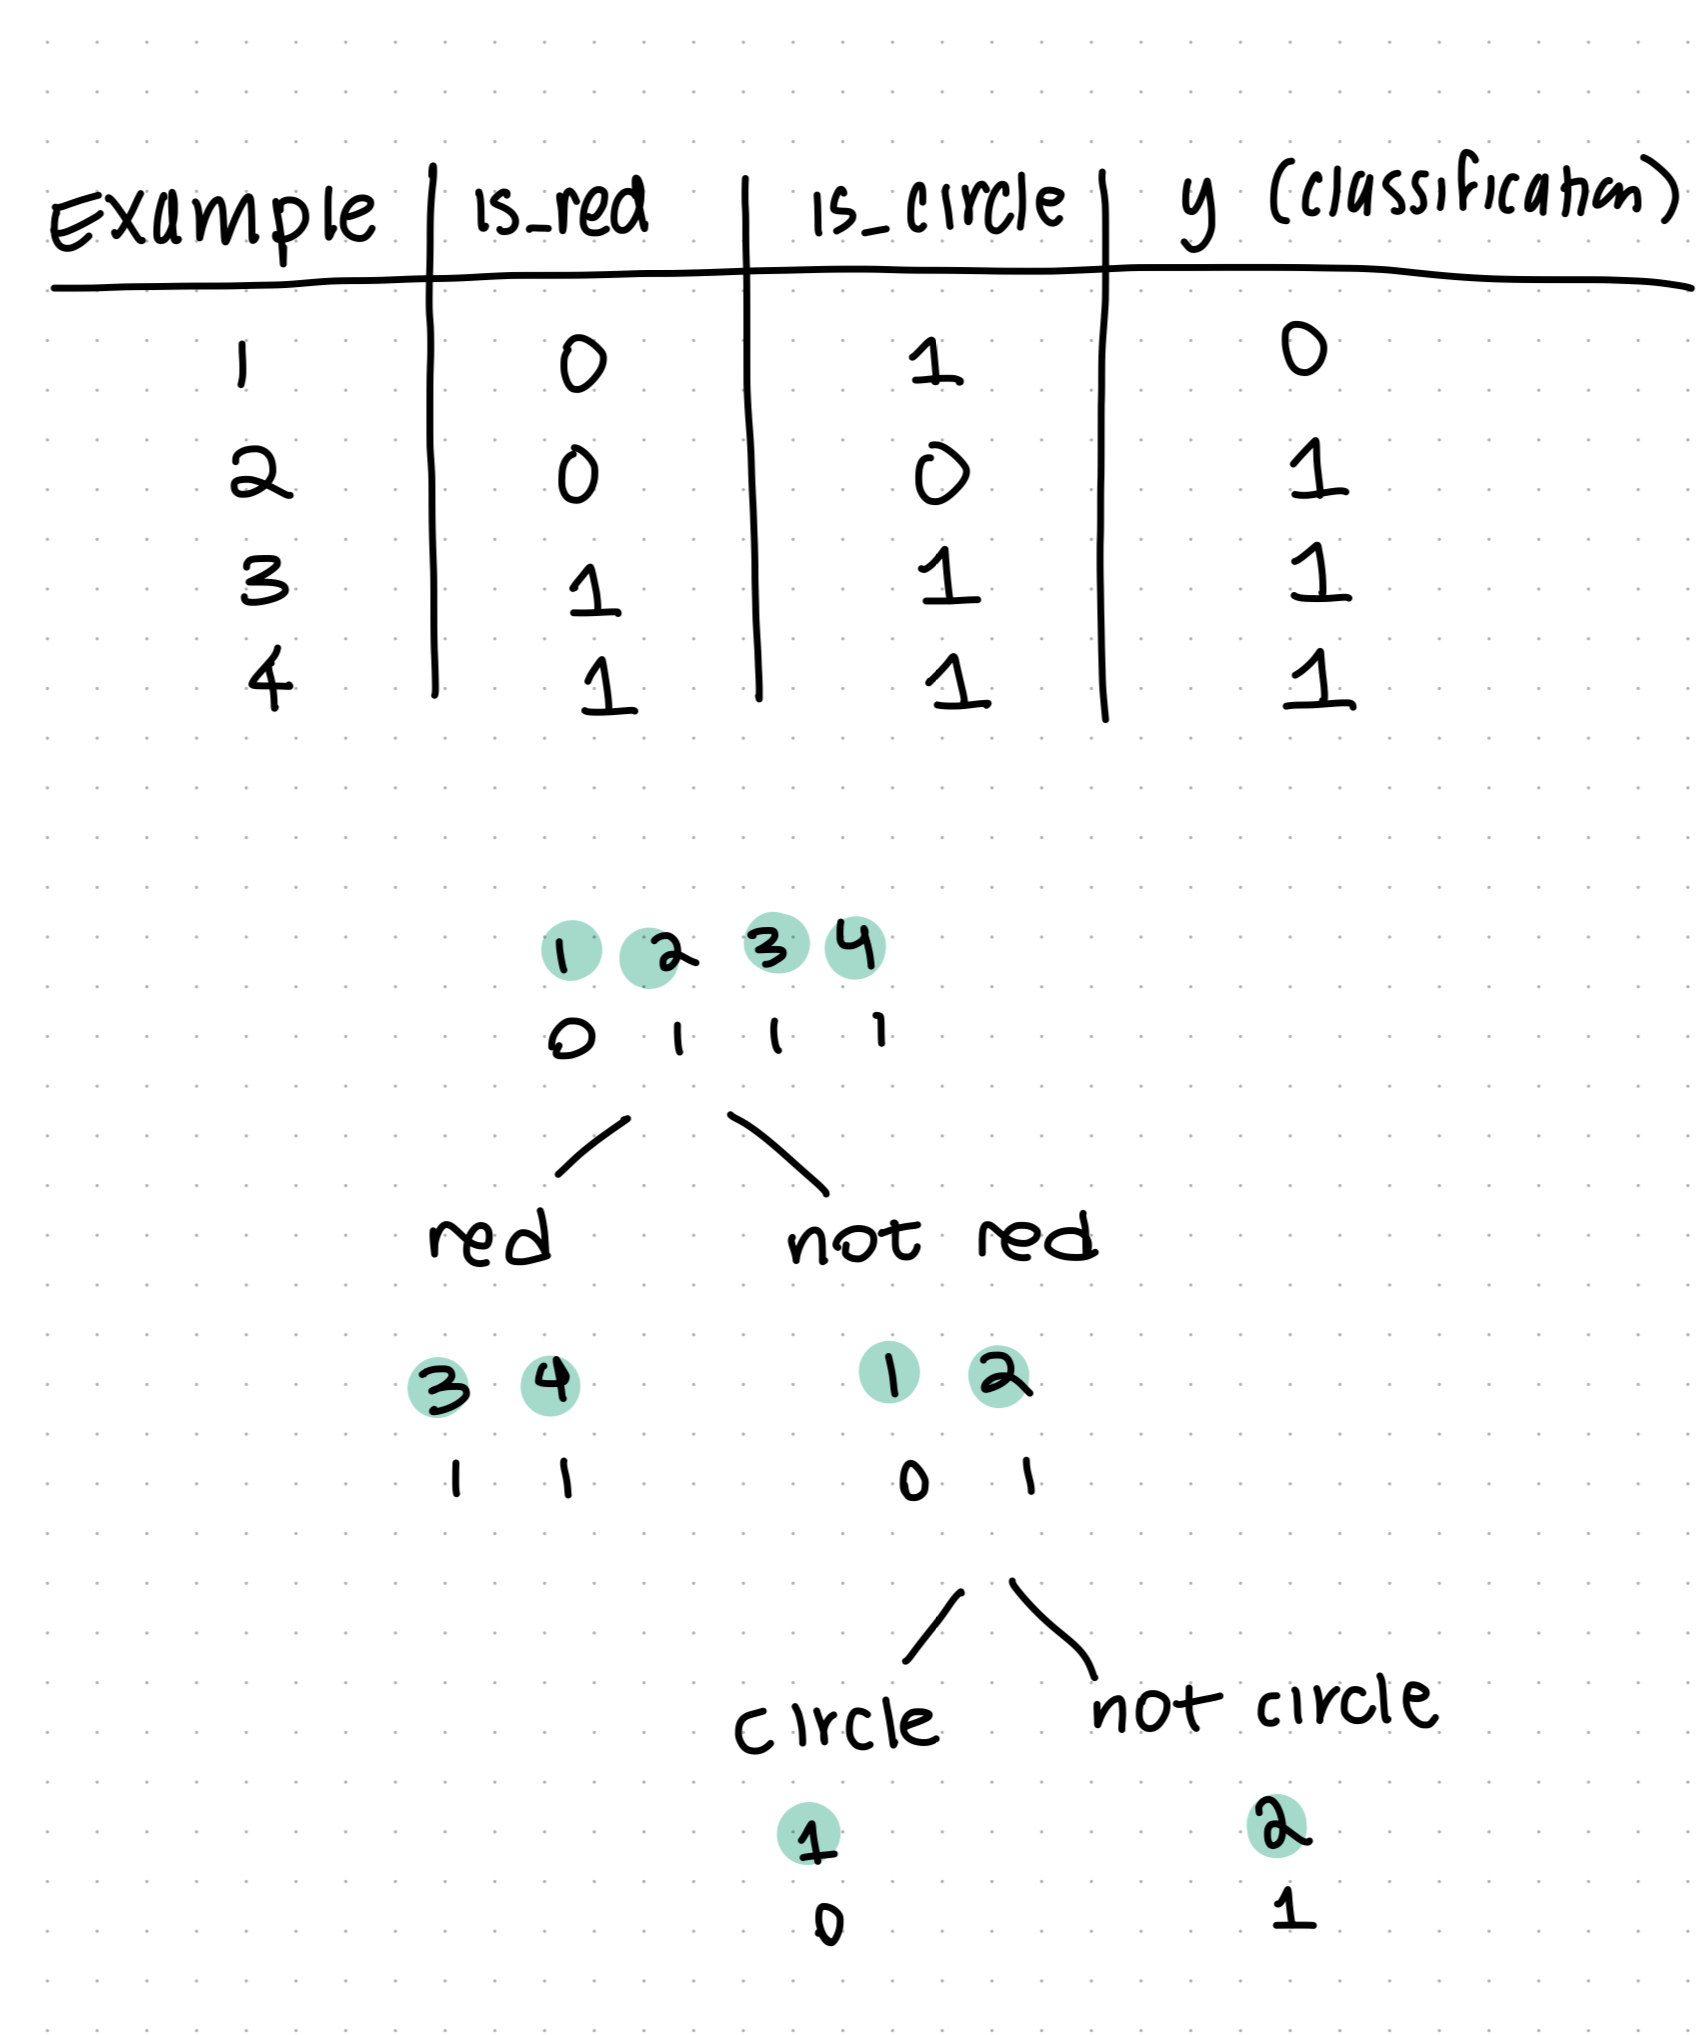


**Key Takeaway for Intuition**

Want to maximize Information Gain:

IG = entropy(parent) - weighted average entropy(children)

where entropy is lower for more pure groups of data (where a majority is one class)

Alternatively, we can use the gini index which achieves a similar goal of measuring how well we distinguish classes but can only be applied to binary classes.

The best splitting decision among candidates is whichever feature gets us closer to _complete separation of classes_ after the split; that's the one that does a better job because we're close to achieving our goal of perfect classification!

This is formally measured / quantified through _Entropy_ and _Information Gain_, but we won't get into the Math now. See the Appendix for a more in-depth discussion.

**Pitfalls**

While very interpretable, single decision trees have a tendency to **_OVERFIT_** to the training data. So is there an improvement?

## Example

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def build_decision_tree(max_depth = None):
  # Instantiate DT with some chosen hyperparameters
  dt = DecisionTreeClassifier(random_state = 0, max_depth = max_depth)

  # Fit to original data (why doesn't this have to be scaled?)
  dt.fit(x_train, y_train)

  # Predict on training and testing sets
  train_pred_dt = dt.predict(x_train)
  test_pred_dt = dt.predict(x_test)

  print("Training Accuracy : %.4f, Testing Accuracy: %.4f"%(
    accuracy_score(y_train, train_pred_dt), accuracy_score(y_test, test_pred_dt)))
  print("Training F1 Score : %.4f, Testing F1 Score: %.4f"%(
    f1_score(y_train, train_pred_dt), f1_score(y_test, test_pred_dt)))
  return dt
dt = build_decision_tree(max_depth = None) # unbounded max depth

Training Accuracy : 1.0000, Testing Accuracy: 0.9837
Training F1 Score : 1.0000, Testing F1 Score: 0.9680


**Recall: Overfitting and Underfitting**
- By having training and testing sets, we can evaluate/score them independently then make a judgment about how good our model is.
  - _Underfit:_ model performs poorly on both familiar data (training) and unfamiliar/unseen data (testing)
  - _Overfit:_ model performs well on familiar data (training) but not as well on unfamiliar/unseen data (testing). This suggests that our model became too acclimated to what it was trained with and cannot generalize well.

**Let's decrease the complexity of the classifier and see how the performance changes**

In [ ]:
dt = build_decision_tree(max_depth = 8)

Training Accuracy : 0.8858, Testing Accuracy: 0.8749
Training F1 Score : 0.7445, Testing F1 Score: 0.7264


In [ ]:
dt = build_decision_tree(max_depth = 1)

Training Accuracy : 0.8197, Testing Accuracy: 0.8159
Training F1 Score : 0.6066, Testing F1 Score: 0.6097


In [ ]:
best_feature_idx = np.argmax(dt.feature_importances_)
best_feature = features.columns[best_feature_idx]
print("The %d-th feature called **%s** is the most importance feature"%(best_feature_idx, best_feature))

The 2-th feature called **favorites** is the most importance feature


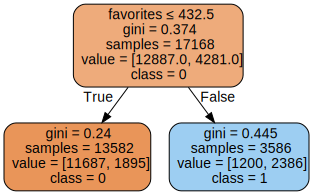

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt, out_file=None, feature_names=x_train.columns,
                           class_names=['0', '1'], filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree") # Save the tree as a PDF file
graph # Display the tree in Jupyter Notebook

In [ ]:
#######################
# feature --[Model]---> if "favorite" < threshold  -------> prediction: [0: not above average]
#                   |
#                   |
#                   --> if "favorite" >= threshold -------> prediction: [1: is above average]
########################

from sklearn.metrics import accuracy_score

def equvalent_predict(feature_data):
  # Use .iloc for integer-location based indexing
  # feature_data.iloc[:, best_feature_idx] selects all rows (:)
  # and the column at index best_feature_idx.
  return [0 if favorite_val <= 432.5 else 1 for favorite_val in feature_data.iloc[:, best_feature_idx]]

train_pred_dt = equvalent_predict(x_train)
test_pred_dt = equvalent_predict(x_test)

print("Training Accuracy : %.4f, Testing Accuracy: %.4f"%(
    accuracy_score(train_pred_dt, y_train), accuracy_score(test_pred_dt, y_test)))

Training Accuracy : 0.8197, Testing Accuracy: 0.8159


## Validation curve: from underfitting to overfitting

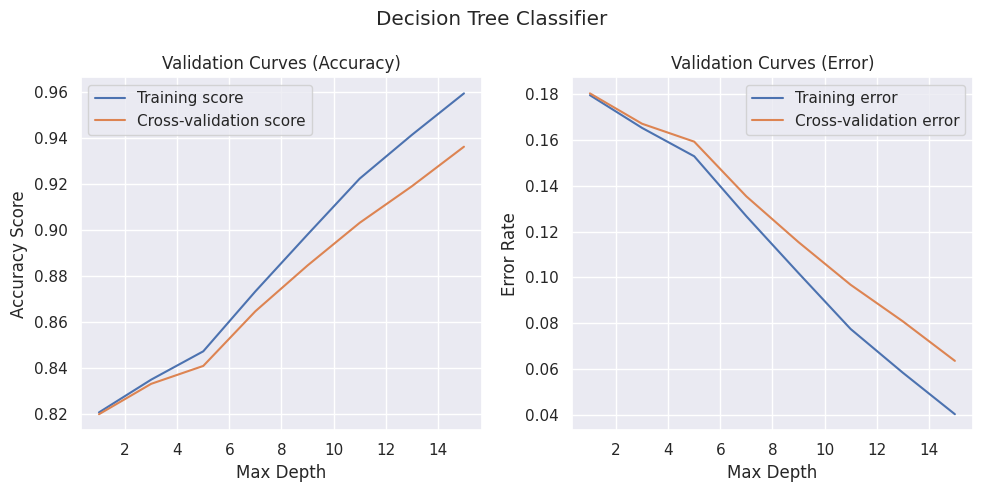

In [ ]:
from sklearn.model_selection import validation_curve
# define the hyperparameter range to explore
param_range = [1, 3, 5, 7, 9, 11, 13, 15]
clf = DecisionTreeClassifier(random_state = 0)

# generate the validation curve data
train_scores, test_scores = validation_curve(estimator=clf, X=x_train, y=y_train, param_name="max_depth", param_range=param_range, cv=5)

plt.figure(figsize=(10,5))
plt.subplot(121)
# plot the validation curve
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score")
plt.plot(param_range, np.mean(test_scores, axis=1), label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curves (Accuracy)")

plt.subplot(122)
# plot the validation curve
plt.plot(param_range, 1-np.mean(train_scores, axis=1), label="Training error")
plt.plot(param_range, 1-np.mean(test_scores, axis=1), label="Cross-validation error")
plt.legend(loc="best")
plt.xlabel("Max Depth")
plt.ylabel("Error Rate")
plt.title("Validation Curves (Error)")
plt.suptitle("Decision Tree Classifier")
plt.tight_layout()
plt.show()

# Bagged Decision Trees

**Introduction to Ensemble Models**

- This is an example of an **ensemble** model: instead of using one single decision tree, we train _many_ decision trees and aggregate their predictions to arrive at a final prediction.
- This process of "averaging" the predictions of many trees ends up covering each other's bases so we arrive at a final result that's less likely to overfit.

**What are Bagged Trees?**

- "Bagging" is actually portmanteau of "Bootstrap" and "Aggregating".
- _Bootstrap_ = create a synthetic dataset by randomly sampling observations/rows **_with_ replacement** (i.e. we could end up having the same datapoint twice)
- _Aggregation_ = the process of aggregating the predictions as outlined above.

These reduce the amount of overfitting compared to single Decision Trees, but may still overfit. Can we improve this even further?

# Random Forest

**What are Random Forests?**

As the name suggests, the term "forests" refers to multiple trees while the term "random" refers to two elements
1. Random subset of observations/rows _**with**_ replacement (i.e. same as bagging).
2. Random subset of features/columns _**without**_ replacement at a given node (i.e. instead of comparing all feature candidates for a given split decision, only a subset of them is compared).

**Hence, random forest is an extension of bagging that also randomly selects subsets of features used in each data sample.**

This second element of randomness further reduces the overfitting when we aggregate the predictions of the multiple trees in the "forest".
<!--
**Implementation**

_(Note: This will take 2-3 minutes to train)_ -->

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None)


# Fit the model to the training data
rf_model.fit(x_train, y_train)

# Predict on the training data
y_train_pred = rf_model.predict(x_train)

# Predict on the testing data
y_test_pred = rf_model.predict(x_test)

In [ ]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


# Calculate F1-score
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Training F1-score: {train_f1:.4f}")
print(f"Testing F1-score: {test_f1:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.9555
Training F1-score: 1.0000
Testing F1-score: 0.9061
